# Data Import

## Library Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import argmax
import cv2
import glob
import pydicom as dicom
import random as ran
from scipy.ndimage.interpolation import rotate

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import l2, l1
from keras.optimizers import SGD

Using TensorFlow backend.


## Training Label CSV Transformation

The training labels come in the format:

<table>
    <tr>
        <th>
            ID
        </th>
        <th>
            Label
        </th>
    </tr>
    <tr>
        <td>
            12345_intraparenchymal
        </td>
        <td>
            1
        </td>
    </tr>
    <tr>
        <td>
            12345_subarachnoid
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            12345_subdural
        </td>
        <td>
            1
        </td>
    </tr>
    <tr>
        <td>
            12345_intraventricular
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            12345_epidural
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            12345_any
        </td>
        <td>
            1
        </td>
    </tr>
</table>

Where each patient ID (`ID`) has six individual rows, each one providing one of the six forms of hemorrhaging along with a boolean column indicating whether that type of hemorrhaging is present in the image.

This format requires some transformation before it can be used in a model. All patient IDs on a single row, with a list of hemorrhage types indicating which are present in that ID will be much more conducive to one hot encoding and eventual classification.

To do this, first I needed to separate the data into two pd.Series; one for IDs that did have hemorrhaging and one for IDs with no hemorrhaging. This is because of the six row per ID format, I needed to perform different transformations on positive and negative IDs. After this, all that was required was grouping by the IDs, then performing the specific transformation for each type of label. The results was:

<table>
    <tr>
        <th>
            ID
        </th>
        <th>
            hem
        </th>
    </tr>
    <tr>
        <td>
            ID_12345
        </td>
        <td>
            [intraparenchymal, subdural, any]
        </td>
    </tr>
    <tr>
        <td>
            ID_22345
        </td>
        <td>
            [subarachnoid, any]
        </td>
    </tr>
    <tr>
        <td>
            ID_32345
        </td>
        <td>
            [none]
        </td>
    </tr>
</table>

In [2]:
train_csv = pd.read_csv('C:/users/sourp/documents/github_repos/ihd_data/data/stage_1_train.csv')
#train_csv = pd.read_csv("./data/stage_1_train.csv")
print('Length of train_csv:',str(len(train_csv)))
print('Expected length of post-tranform train_labels:', str(int(len(train_csv)/6)))

train_csv['hem'] = train_csv['ID'].str.split('_').str[2]

train_labels_pos = train_csv.loc[train_csv['Label']==1].groupby([train_csv['ID'].str.split('_').str[1]
                                                                ])['hem'].apply(lambda x: "%s" % '_'.join(x))
train_labels_neg = train_csv.groupby([train_csv["ID"].str.split("_").str[1]]).sum()
train_labels_neg[train_labels_neg == 0] = 'none'
train_labels_neg = train_labels_neg[train_labels_neg == 'none']
train_labels_neg.dropna(inplace=True)

train_labels = train_labels_pos.append(train_labels_neg['Label'])
print(train_labels.head())

train_labels.index = 'ID_'+train_labels.index
train_labels = train_labels.str.split('_')

print(train_labels.head())
print('Training labels created.\nLength of train_labels: '+str(len(train_labels)))

Length of train_csv: 4045572
Expected length of post-tranform train_labels: 674262
ID
0002081b6         intraparenchymal_any
0002a38ad    subarachnoid_subdural_any
000346ce2                 subdural_any
00042829c         intraventricular_any
0004a5701                 subdural_any
dtype: object
ID_0002081b6          [intraparenchymal, any]
ID_0002a38ad    [subarachnoid, subdural, any]
ID_000346ce2                  [subdural, any]
ID_00042829c          [intraventricular, any]
ID_0004a5701                  [subdural, any]
dtype: object
Training labels created.
Length of train_labels: 674258


## Images Import and Labeling

The images come in the dicom image format. This format is one of the standard image formats for CT scan images and has a unique and helpful feature in the form of metadata.

With this robust metadata, you can have access to many different attributes and labels associated with the image. Using the format `image.attribute` you can access this information.

In this case, I need the `image.pixel_array` to actually load the image into python and `image.SOPInstanceUID` which is the patient ID I can then use to match up images with their respective training label.

All images are then loaded into an np.array, then transferred to a dictionary in one key, while a second key holds the labels for each image.

In [3]:
def import_images(total_images, hem_rate):
    image_arrays = []
    labels = []
    image_counter = 0
    total_images = total_images
    hem_img_count = 0
    total_hem_img_count = int(total_images*hem_rate)

    files = glob.glob("C:/users/sourp/documents/github_repos/ihd_data/data/stage_1_train_images/*.dcm")
    #files = glob.glob("./data/stage_1_train_images/*.dcm")
    ran.shuffle(files)

    for im_file in files:
        if image_counter < total_images:
            try:
                image = dicom.dcmread(im_file)
                image_array = image.pixel_array
                image_array_resized = cv2.resize(image_array,(50,50))
                image_label = train_labels.loc[train_labels.index==str(image.SOPInstanceUID)][0]

                if 'any' in image_label and hem_img_count < total_hem_img_count:
                    if image_counter % 1000 == 0 and image_counter != 0:
                        print(str(image_counter), 'images imported.')
                    image_arrays.append(image_array_resized)
                    labels.append(image_label)
                    hem_img_count += 1
                    image_counter += 1
                elif hem_img_count >= total_hem_img_count:
                    if image_counter % 1000 == 0 and image_counter != 0:
                        print(str(image_counter), 'images imported.')
                    image_arrays.append(image_array_resized)
                    labels.append(image_label)
                    image_counter += 1    
            except:
                pass
        else:
            break

    print('Import complete.'+'\n\n'+'images: ' + str(image_counter)+'\n')

    data = {'images': np.asarray(image_arrays), 'labels': np.asarray(labels)}
    print(data['images'][0],'\n\n',data['labels'][0])
    
    return data

In [ ]:
data = import_images(100000, .9)
test_data = import_images(25000, .9)

# Data Examination

## Image Example

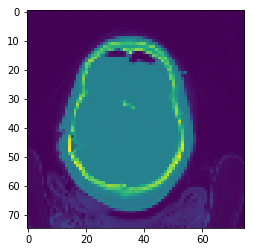

In [39]:
random_index = ran.randint(0, image_counter-1)
random_scan = data['images'][random_index][:,:]/255

plt.imshow(random_scan);

## Label Information

In [40]:
unique_labels, label_counts = np.unique(data['labels'], return_counts=True)

index = 0
for i in unique_labels:
    print(i,'-- Occurences:',label_counts[index])
    index += 1

['epidural', 'any'] -- Occurences: 865
['epidural', 'intraparenchymal', 'any'] -- Occurences: 131
['epidural', 'intraparenchymal', 'intraventricular', 'any'] -- Occurences: 29
['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'any'] -- Occurences: 24
['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any'] -- Occurences: 14
['epidural', 'intraparenchymal', 'intraventricular', 'subdural', 'any'] -- Occurences: 11
['epidural', 'intraparenchymal', 'subarachnoid', 'any'] -- Occurences: 44
['epidural', 'intraparenchymal', 'subarachnoid', 'subdural', 'any'] -- Occurences: 28
['epidural', 'intraparenchymal', 'subdural', 'any'] -- Occurences: 41
['epidural', 'intraventricular', 'any'] -- Occurences: 26
['epidural', 'intraventricular', 'subarachnoid', 'any'] -- Occurences: 8
['epidural', 'intraventricular', 'subarachnoid', 'subdural', 'any'] -- Occurences: 16
['epidural', 'intraventricular', 'subdural', 'any'] -- Occurences: 11
['epidural', 'sub

# Data Transformation

In [41]:
X_temp = data['images']/255

X = np.empty(shape=[X_temp.shape[0]] + [2500], dtype='float32')
print(X_temp.shape)

for im in range(X_temp.shape[0]):
    X[im,:] = X_temp[im,:,:].flatten()

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['labels'])

print(y[:10])
print(X_temp.shape)
print(X.shape)
print(y.shape)
X[0,:]

(100000, 75, 75)
[[1 0 0 0 0 1 0]
 [1 0 0 0 0 1 0]
 [1 0 0 0 0 0 1]
 [1 0 0 0 0 0 1]
 [1 0 1 1 0 0 0]
 [1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0]
 [1 0 0 0 0 1 1]
 [1 0 0 1 0 0 0]
 [1 0 0 0 0 0 1]]
(100000, 75, 75)
(100000, 5625)
(100000, 7)


array([0.09019608, 0.08627451, 0.09411765, ..., 0.35686275, 0.2901961 ,
       0.17254902], dtype=float32)

In [42]:
# Neural Network train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=50)

print (X_train.shape)
print (y_train.shape)

(75000, 5625)
(75000, 7)


In [43]:
stdscaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = stdscaler.transform(X_train)
X_test_scaled  = stdscaler.transform(X_test)

# Neural Network Model

In [44]:
label_count = len(mlb.classes_)

model = Sequential()

model.add(Dense(label_count*24, input_shape=[2500], activation='relu', W_regularizer=l2(0.1)))
model.add(Dense(label_count*18, activation='relu', W_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(label_count*12, activation='relu', W_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(label_count*8, activation='relu', W_regularizer=l2(0.001)))
model.add(Dense(label_count, activation='sigmoid', W_regularizer=l1(0.001)))

sgd = SGD(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(168, input_shape=[5625], activation="relu", kernel_regularizer=<keras.reg...)`
  """
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(126, activation="relu", kernel_regularizer=<keras.reg...)`
  
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(84, activation="relu", kernel_regularizer=<keras.reg...)`
  
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(56, activation="relu", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(7, activation

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 168)               945168    
_________________________________________________________________
dense_7 (Dense)              (None, 126)               21294     
_________________________________________________________________
dropout_3 (Dropout)          (None, 126)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 84)                10668     
_________________________________________________________________
dropout_4 (Dropout)          (None, 84)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 56)                4760      
_________________________________________________________________
dense_10 (Dense)             (None, 7)                

In [46]:
history = model.fit(X_train_scaled, y_train, batch_size = 256, 
                    epochs = 100, verbose=2, validation_data=(X_test_scaled, y_test))

Train on 75000 samples, validate on 25000 samples
Epoch 1/100
 - 7s - loss: 4.8662 - accuracy: 0.7985 - val_loss: 1.3308 - val_accuracy: 0.8139
Epoch 2/100
 - 5s - loss: 1.0160 - accuracy: 0.8130 - val_loss: 0.7902 - val_accuracy: 0.8142
Epoch 3/100
 - 5s - loss: 0.6891 - accuracy: 0.8128 - val_loss: 0.6152 - val_accuracy: 0.8120
Epoch 4/100
 - 5s - loss: 0.5786 - accuracy: 0.8129 - val_loss: 0.5473 - val_accuracy: 0.8139
Epoch 5/100
 - 5s - loss: 0.5374 - accuracy: 0.8124 - val_loss: 0.5225 - val_accuracy: 0.8140
Epoch 6/100
 - 5s - loss: 0.5174 - accuracy: 0.8127 - val_loss: 0.5060 - val_accuracy: 0.8149
Epoch 7/100
 - 5s - loss: 0.5066 - accuracy: 0.8125 - val_loss: 0.5022 - val_accuracy: 0.8148
Epoch 8/100
 - 5s - loss: 0.4994 - accuracy: 0.8120 - val_loss: 0.4945 - val_accuracy: 0.8139
Epoch 9/100
 - 5s - loss: 0.4932 - accuracy: 0.8126 - val_loss: 0.4871 - val_accuracy: 0.8131
Epoch 10/100
 - 5s - loss: 0.4884 - accuracy: 0.8122 - val_loss: 0.4831 - val_accuracy: 0.8136
Epoch 11/

Epoch 87/100
 - 5s - loss: 0.4523 - accuracy: 0.8130 - val_loss: 0.4615 - val_accuracy: 0.8080
Epoch 88/100
 - 5s - loss: 0.4512 - accuracy: 0.8141 - val_loss: 0.4514 - val_accuracy: 0.8119
Epoch 89/100
 - 5s - loss: 0.4529 - accuracy: 0.8127 - val_loss: 0.4570 - val_accuracy: 0.8132
Epoch 90/100
 - 5s - loss: 0.4519 - accuracy: 0.8132 - val_loss: 0.4548 - val_accuracy: 0.8137
Epoch 91/100
 - 5s - loss: 0.4522 - accuracy: 0.8133 - val_loss: 0.4471 - val_accuracy: 0.8139
Epoch 92/100
 - 5s - loss: 0.4516 - accuracy: 0.8134 - val_loss: 0.4512 - val_accuracy: 0.8120
Epoch 93/100
 - 5s - loss: 0.4516 - accuracy: 0.8136 - val_loss: 0.4479 - val_accuracy: 0.8152
Epoch 94/100
 - 5s - loss: 0.4521 - accuracy: 0.8129 - val_loss: 0.4496 - val_accuracy: 0.8128
Epoch 95/100
 - 5s - loss: 0.4519 - accuracy: 0.8131 - val_loss: 0.4480 - val_accuracy: 0.8156
Epoch 96/100
 - 5s - loss: 0.4517 - accuracy: 0.8132 - val_loss: 0.4605 - val_accuracy: 0.8059
Epoch 97/100
 - 5s - loss: 0.4520 - accuracy: 0.81

BC after final iteration:  0.4495619329071045


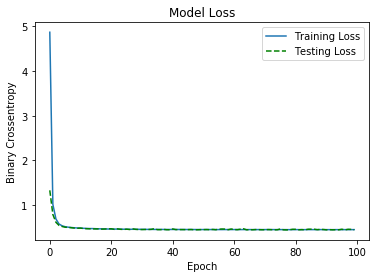

In [47]:
fig = plt.figure(figsize=(6,4))

# Summary of loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'g--')
plt.title('Model Loss')
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
print ("BC after final iteration: ", history.history['val_loss'][-1])
plt.show()

Accuracy after final iteration:  0.815371572971344


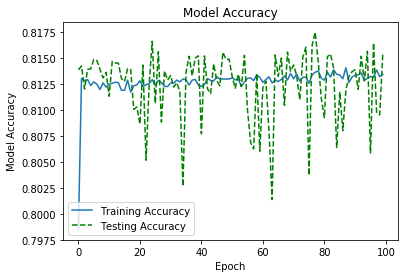

In [48]:
fig = plt.figure(figsize=(6,4))

# Summary of accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], 'g--')
plt.title('Model Accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='lower left')
print ("Accuracy after final iteration: ", history.history['val_accuracy'][-1])
plt.show()

## Test Model

In [ ]:
from sklearn.metrics import classification_report

y_pred = history.predict(x_test2, batch_size=64, verbose=1)
y_actual = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_actual))